In [45]:
import os

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torch.utils.data as data
import torchvision.transforms as transforms
import torch.nn.functional as F
from pydicom import Dataset
from PIL import Image
from tqdm import tqdm

from medmnist import BreastMNIST
from medmnist import INFO

import pennylane as qml

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, roc_curve, auc

In [46]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print(f"Using: {torch.cuda.get_device_name(0)}")
    print(f"CUDA: {torch.version.cuda}")
else:
    print("CUDA is not available. Using CPU.")

Using: NVIDIA GeForce RTX 4070 Ti SUPER
CUDA: 12.4


In [47]:
class BCDRDataset(Dataset):
    def __init__(self, root_dir, train=True, data_augmentation=True):
        self.image_paths = []
        self.labels = []
        
        base_transform = [
            transforms.Resize((128, 128)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5186, 0.5187, 0.5185], std=[0.1957, 0.1957, 0.1957])
        ]

        augmentation_transform = [
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomRotation(degrees=15)
        ]

        if train and data_augmentation:
            self.transform = transforms.Compose(augmentation_transform + base_transform)
        else:
            self.transform = transforms.Compose(base_transform)

        for label in ['0', '1']:
            folder_path = os.path.join(root_dir, label)
            images = sorted(os.listdir(folder_path)) 
            self.image_paths.extend([os.path.join(folder_path, img_name) for img_name in images])
            self.labels.extend([int(label)] * len(images))

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert('RGB')
        image = self.transform(image)
        label = torch.tensor(self.labels[idx], dtype=torch.long)  
        return image, label

## **Dataloader: Train and Test**

In [48]:
train_dir = '/home/eflammere/BreastCancerQuanvolution/Datasets/BCDR/png/train/'
test_dir = '/home/eflammere/BreastCancerQuanvolution/Datasets/BCDR/png/test'

train_dataset = BCDRDataset(root_dir=train_dir, train=True)
test_dataset = BCDRDataset(root_dir=test_dir, train=False)

batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# **Quanvolution**

Designed to process an image by applying a quantum circuit to extract features from it. It works similarly to a convolutional layer in a neural network, but instead of using traditional mathematical filters, it leverages a quantum circuit to process small patches of the image and generate new features.

In [49]:
def quanvolution(image, circuit, patch_size, n_qubits):
    """
    Perform quanvolution on the input image using the given quantum circuit.
    
    Args:
    - image (ndarray): The input image (2D or 3D with channels).
    - circuit (function): The quantum circuit function to extract features.
    - patch_size (int): The size of the patches to divide the image into.
    - n_qubits (int): Number of qubits in the quantum circuit.
    
    Returns:
    - out (ndarray): The output tensor after quanvolution.
    """
    if image.ndim == 2:
        image = np.expand_dims(image, axis=-1)
    
    height_patches = image.shape[0] // patch_size
    width_patches = image.shape[1] // patch_size
    
    out = np.zeros((height_patches, width_patches, n_qubits))
    
    for j in range(height_patches):
        for k in range(width_patches):
            patch = []
            for i in range(patch_size):
                for l in range(patch_size):
                    if (j * patch_size + i < image.shape[0]) and (k * patch_size + l < image.shape[1]):
                        patch.append(image[j * patch_size + i, k * patch_size + l, 0])
                    else:
                        patch.append(0)
            
            q_results = circuit(patch)
            
            for c in range(n_qubits):
                out[j, k, c] = q_results[c]
    
    return out

def quanvolution_batch(images, circuit, patch_size, n_qubits):
    """
    Applies quanvolution to a batch of images.

    Args:
    - images: Input tensor (batch_size, H, W, C).
    - circuit: Quantum circuit used for the quanvolution.
    - patch_size: Size of the patches used in the quanvolution.
    - n_qubits: Number of qubits in the quantum circuit.

    Returns:
    - Processed tensor after quanvolution.
    """
    batch_size = images.shape[0]
    processed = [
        quanvolution(images[i].detach().cpu().numpy(), circuit, patch_size, n_qubits)
        for i in range(batch_size)
    ]

    processed = np.array(processed)
    return torch.tensor(processed, dtype=torch.float32).to(images.device)

In [50]:
n_qubits = 4
n_layers = 1

rand_params = np.random.uniform(high=2 * np.pi, size=(n_layers, n_qubits))

def get_device(n_qubits):
    return qml.device("lightning.gpu", wires=n_qubits)

def define_circuit(rand_params):
    """
    Define a parametrized quantum circuit with custom layers and RandomLayers.

    Args:
    - rand_params: Parameters for the circuit layers.

    Returns:
    - A quantum circuit function (qml.QNode).
    """
    dev = get_device(n_qubits)

    @qml.qnode(dev, interface='torch')
    def circuit(phi):
        for j in range(n_qubits):
            qml.RY(np.pi * phi[j], wires=j)

        qml.templates.layers.RandomLayers(rand_params, list(range(n_qubits)))

        return [qml.expval(qml.PauliZ(j)) for j in range(n_qubits)]

    return circuit

rand_circuit = define_circuit(rand_params)

phi = np.random.uniform(size=n_qubits)

result = rand_circuit(phi)

expanded_circuit = rand_circuit.qtape.expand()
print(expanded_circuit.draw())

0: ──RY────────────────┤  <Z>
1: ──RY──RY─╭●─────────┤  <Z>
2: ──RY──RX─│───RZ──RX─┤  <Z>
3: ──RY─────╰X─────────┤  <Z>


## **Quanvolution4x1**

*4 qubits & 1 quanvolution*

In [51]:
class Quanvolution4x1Model(nn.Module):
    def __init__(self, rand_params, output_size = (32, 32), patch_size = 4, n_qubits = 4, num_classes = 2):
        """
        Defines the CNN with quanvolution.

        Args:
        - rand_params: Parameters of the quantum circuit.
        - output_size: Output size after quanvolution.
        - n_qubits: Number of qubits in the quantum circuit.
        - num_classes: Number of classes for classification.
        """
        super(Quanvolution4x1Model, self).__init__()
        self.output_size = output_size
        self.patch_size = patch_size
        self.n_qubits = n_qubits
        self.num_classes = num_classes
        
        self.circuit = define_circuit(rand_params)

        self.flatten = nn.Flatten()
        self.fc = nn.Linear(output_size[0] * output_size[1] * n_qubits, num_classes)

    def forward(self, x):
        """
        Passes the data through the network.

        Args:
        - x: Input tensor (batch_size, C, H, W).
        
        Returns:
        - Logarithmic probabilities of the classes (batch_size, num_classes).
        """
        x = x.permute(0, 2, 3, 1)
        x = quanvolution_batch(x, self.circuit, self.patch_size, self.n_qubits)
        x = torch.relu(x)
        x = self.flatten(x)
        x = self.fc(x)
        return F.log_softmax(x, dim=1)

In [52]:
model = Quanvolution4x1Model(rand_params).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.1) 
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
criterion = nn.CrossEntropyLoss().to(device)
epochs = 20

In [53]:
last_model_path = "/home/eflammere/BreastCancerQuanvolution/Quantum/checkpoints/BCDR/224x224/1/last_model.pth"
checkpoint_frequency = 2

train_losses = []


for epoch in range(epochs):
    print(f"\nEpoch {epoch + 1}/{epochs}")

    model.train()
    total_loss = 0.0
    print("\n[Training]")

    for batch_idx, (images, labels) in enumerate(tqdm(train_loader, desc="Training Batches", bar_format="{desc}: {n}/{total}")):
        images, labels = images.squeeze(1).to(device), labels.squeeze().to(device)

        optimizer.zero_grad()
        output = model(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        batch_accuracy = accuracy_score(
            labels.cpu().numpy(), output.argmax(dim=1).cpu().numpy()
        )

        print(f"Loss: {loss.item():.4f}, Accuracy: {batch_accuracy:.3f}")

    epoch_train_loss = total_loss / len(train_loader)
    train_losses.append(epoch_train_loss)
    print(f"Epoch {epoch + 1} Training Loss: {epoch_train_loss:.4f}")

    scheduler.step()

    if (epoch + 1) % checkpoint_frequency == 0:
        checkpoint_path = f"/home/eflammere/BreastCancerQuanvolution/Quantum/checkpoints/BCDR/224x224/1/model_checkpoint_epoch_{epoch + 1}.pth"
        torch.save(model.state_dict(), checkpoint_path)
        print("Checkpoint saved.")

torch.save(model.state_dict(), last_model_path)
print("Last model saved.")


Epoch 1/20

[Training]


Training Batches: 1/7

Loss: 0.6154, Accuracy: 0.688


Training Batches: 2/7

Loss: 6.2569, Accuracy: 0.969


Training Batches: 3/7

Loss: 57.9240, Accuracy: 0.812


Training Batches: 4/7

Loss: 48.4337, Accuracy: 0.844


Training Batches: 5/7

Loss: 90.3451, Accuracy: 0.688


Training Batches: 6/7

Loss: 44.9308, Accuracy: 0.781


Training Batches: 7/7


Loss: 16.9166, Accuracy: 0.806
Epoch 1 Training Loss: 37.9175

Epoch 2/20

[Training]


Training Batches: 1/7

Loss: 31.9271, Accuracy: 0.188


Training Batches: 2/7

Loss: 19.4583, Accuracy: 0.250


Training Batches: 3/7

Loss: 2.8818, Accuracy: 0.938


Training Batches: 4/7

Loss: 17.4793, Accuracy: 0.812


Training Batches: 5/7

Loss: 24.8471, Accuracy: 0.812


Training Batches: 6/7

Loss: 23.6131, Accuracy: 0.844


Training Batches: 7/7


Loss: 35.3912, Accuracy: 0.774
Epoch 2 Training Loss: 22.2283
Checkpoint saved.

Epoch 3/20

[Training]


Training Batches: 1/7

Loss: 4.4074, Accuracy: 0.969


Training Batches: 2/7

Loss: 33.0086, Accuracy: 0.750


Training Batches: 3/7

Loss: 31.5564, Accuracy: 0.688


Training Batches: 4/7

Loss: 16.8734, Accuracy: 0.688


Training Batches: 5/7

Loss: 6.1969, Accuracy: 0.406


Training Batches: 6/7

Loss: 22.4831, Accuracy: 0.062


Training Batches: 7/7


Loss: 2.2387, Accuracy: 0.903
Epoch 3 Training Loss: 16.6806

Epoch 4/20

[Training]


Training Batches: 1/7

Loss: 12.9697, Accuracy: 0.719


Training Batches: 2/7

Loss: 9.1259, Accuracy: 0.844


Training Batches: 3/7

Loss: 11.9129, Accuracy: 0.781


Training Batches: 4/7

Loss: 5.9954, Accuracy: 0.875


Training Batches: 5/7

Loss: 7.4453, Accuracy: 0.781


Training Batches: 6/7

Loss: 1.8824, Accuracy: 0.781


Training Batches: 7/7


Loss: 17.2541, Accuracy: 0.129
Epoch 4 Training Loss: 9.5123
Checkpoint saved.

Epoch 5/20

[Training]


Training Batches: 1/7

Loss: 2.1681, Accuracy: 0.688


Training Batches: 2/7

Loss: 2.9666, Accuracy: 0.844


Training Batches: 3/7

Loss: 4.1232, Accuracy: 0.875


Training Batches: 4/7

Loss: 7.3259, Accuracy: 0.812


Training Batches: 5/7

Loss: 4.8549, Accuracy: 0.844


Training Batches: 6/7

Loss: 2.3866, Accuracy: 0.750


Training Batches: 7/7


Loss: 1.6953, Accuracy: 0.839
Epoch 5 Training Loss: 3.6458

Epoch 6/20

[Training]


Training Batches: 1/7

Loss: 1.6618, Accuracy: 0.719


Training Batches: 2/7

Loss: 0.9764, Accuracy: 0.844


Training Batches: 3/7

Loss: 4.4225, Accuracy: 0.812


Training Batches: 4/7

Loss: 3.3313, Accuracy: 0.812


Training Batches: 5/7

Loss: 1.2226, Accuracy: 0.844


Training Batches: 6/7

Loss: 3.2874, Accuracy: 0.594


Training Batches: 7/7


Loss: 1.4374, Accuracy: 0.839
Epoch 6 Training Loss: 2.3342
Checkpoint saved.

Epoch 7/20

[Training]


Training Batches: 1/7

Loss: 1.9075, Accuracy: 0.781


Training Batches: 2/7

Loss: 1.2243, Accuracy: 0.781


Training Batches: 3/7

Loss: 4.4073, Accuracy: 0.781


Training Batches: 4/7

Loss: 2.2667, Accuracy: 0.781


Training Batches: 5/7

Loss: 1.7079, Accuracy: 0.719


Training Batches: 6/7

Loss: 2.0050, Accuracy: 0.719


Training Batches: 7/7


Loss: 1.6008, Accuracy: 0.645
Epoch 7 Training Loss: 2.1599

Epoch 8/20

[Training]


Training Batches: 1/7

Loss: 2.7999, Accuracy: 0.781


Training Batches: 2/7

Loss: 0.7421, Accuracy: 0.906


Training Batches: 3/7

Loss: 1.1973, Accuracy: 0.812


Training Batches: 4/7

Loss: 1.2939, Accuracy: 0.812


Training Batches: 5/7

Loss: 3.3276, Accuracy: 0.719


Training Batches: 6/7

Loss: 2.4741, Accuracy: 0.750


Training Batches: 7/7


Loss: 1.8163, Accuracy: 0.677
Epoch 8 Training Loss: 1.9502
Checkpoint saved.

Epoch 9/20

[Training]


Training Batches: 1/7

Loss: 1.5436, Accuracy: 0.938


Training Batches: 2/7

Loss: 4.3002, Accuracy: 0.781


Training Batches: 3/7

Loss: 2.3649, Accuracy: 0.688


Training Batches: 4/7

Loss: 1.0652, Accuracy: 0.812


Training Batches: 5/7

Loss: 1.6993, Accuracy: 0.688


Training Batches: 6/7

Loss: 2.7942, Accuracy: 0.750


Training Batches: 7/7


Loss: 0.7333, Accuracy: 0.839
Epoch 9 Training Loss: 2.0715

Epoch 10/20

[Training]


Training Batches: 1/7

Loss: 1.6642, Accuracy: 0.906


Training Batches: 2/7

Loss: 1.0427, Accuracy: 0.812


Training Batches: 3/7

Loss: 1.7382, Accuracy: 0.688


Training Batches: 4/7

Loss: 2.4953, Accuracy: 0.719


Training Batches: 5/7

Loss: 3.8203, Accuracy: 0.719


Training Batches: 6/7

Loss: 2.7849, Accuracy: 0.844


Training Batches: 7/7


Loss: 2.0388, Accuracy: 0.774
Epoch 10 Training Loss: 2.2263
Checkpoint saved.

Epoch 11/20

[Training]


Training Batches: 1/7

Loss: 1.7808, Accuracy: 0.812


Training Batches: 2/7

Loss: 1.9557, Accuracy: 0.812


Training Batches: 3/7

Loss: 1.4642, Accuracy: 0.719


Training Batches: 4/7

Loss: 3.7679, Accuracy: 0.625


Training Batches: 5/7

Loss: 0.7715, Accuracy: 0.906


Training Batches: 6/7

Loss: 0.9175, Accuracy: 0.812


Training Batches: 7/7


Loss: 2.2316, Accuracy: 0.774
Epoch 11 Training Loss: 1.8413

Epoch 12/20

[Training]


Training Batches: 1/7

Loss: 5.1181, Accuracy: 0.750


Training Batches: 2/7

Loss: 2.1371, Accuracy: 0.875


Training Batches: 3/7

Loss: 0.8327, Accuracy: 0.844


Training Batches: 4/7

Loss: 1.7301, Accuracy: 0.844


Training Batches: 5/7

Loss: 2.3335, Accuracy: 0.781


Training Batches: 6/7

Loss: 1.0827, Accuracy: 0.906


Training Batches: 7/7


Loss: 1.5003, Accuracy: 0.871
Epoch 12 Training Loss: 2.1049
Checkpoint saved.

Epoch 13/20

[Training]


Training Batches: 1/7

Loss: 2.3261, Accuracy: 0.906


Training Batches: 2/7

Loss: 2.2290, Accuracy: 0.844


Training Batches: 3/7

Loss: 2.0425, Accuracy: 0.781


Training Batches: 4/7

Loss: 3.5042, Accuracy: 0.719


Training Batches: 5/7

Loss: 2.5899, Accuracy: 0.625


Training Batches: 6/7

Loss: 1.7987, Accuracy: 0.781


Training Batches: 7/7


Loss: 2.0896, Accuracy: 0.710
Epoch 13 Training Loss: 2.3686

Epoch 14/20

[Training]


Training Batches: 1/7

Loss: 0.8071, Accuracy: 0.875


Training Batches: 2/7

Loss: 1.3706, Accuracy: 0.812


Training Batches: 3/7

Loss: 1.2134, Accuracy: 0.812


Training Batches: 4/7

Loss: 1.9104, Accuracy: 0.812


Training Batches: 5/7

Loss: 2.0910, Accuracy: 0.812


Training Batches: 6/7

Loss: 0.4083, Accuracy: 0.938


Training Batches: 7/7


Loss: 1.4559, Accuracy: 0.903
Epoch 14 Training Loss: 1.3224
Checkpoint saved.

Epoch 15/20

[Training]


Training Batches: 1/7

Loss: 1.2982, Accuracy: 0.875


Training Batches: 2/7

Loss: 0.8128, Accuracy: 0.906


Training Batches: 3/7

Loss: 3.5734, Accuracy: 0.688


Training Batches: 4/7

Loss: 0.8319, Accuracy: 0.875


Training Batches: 5/7

Loss: 2.0773, Accuracy: 0.812


Training Batches: 6/7

Loss: 2.7006, Accuracy: 0.781


Training Batches: 7/7


Loss: 0.7595, Accuracy: 0.839
Epoch 15 Training Loss: 1.7219

Epoch 16/20

[Training]


Training Batches: 1/7

Loss: 2.0611, Accuracy: 0.719


Training Batches: 2/7

Loss: 2.1509, Accuracy: 0.750


Training Batches: 3/7

Loss: 0.8225, Accuracy: 0.906


Training Batches: 4/7

Loss: 1.1278, Accuracy: 0.844


Training Batches: 5/7

Loss: 2.3939, Accuracy: 0.781


Training Batches: 6/7

Loss: 1.6797, Accuracy: 0.812


Training Batches: 7/7


Loss: 0.6004, Accuracy: 0.903
Epoch 16 Training Loss: 1.5481
Checkpoint saved.

Epoch 17/20

[Training]


Training Batches: 1/7

Loss: 0.9358, Accuracy: 0.844


Training Batches: 2/7

Loss: 1.3250, Accuracy: 0.875


Training Batches: 3/7

Loss: 2.3200, Accuracy: 0.844


Training Batches: 4/7

Loss: 1.4794, Accuracy: 0.844


Training Batches: 5/7

Loss: 2.5777, Accuracy: 0.688


Training Batches: 6/7

Loss: 1.9135, Accuracy: 0.750


Training Batches: 7/7


Loss: 0.1619, Accuracy: 0.871
Epoch 17 Training Loss: 1.5305

Epoch 18/20

[Training]


Training Batches: 1/7

Loss: 2.0766, Accuracy: 0.812


Training Batches: 2/7

Loss: 0.4028, Accuracy: 0.906


Training Batches: 3/7

Loss: 1.9701, Accuracy: 0.781


Training Batches: 4/7

Loss: 1.0650, Accuracy: 0.844


Training Batches: 5/7

Loss: 0.1348, Accuracy: 0.969


Training Batches: 6/7

Loss: 1.2872, Accuracy: 0.844


Training Batches: 7/7


Loss: 1.4499, Accuracy: 0.774
Epoch 18 Training Loss: 1.1981
Checkpoint saved.

Epoch 19/20

[Training]


Training Batches: 1/7

Loss: 1.4032, Accuracy: 0.812


Training Batches: 2/7

Loss: 1.1268, Accuracy: 0.812


Training Batches: 3/7

Loss: 1.6789, Accuracy: 0.719


Training Batches: 4/7

Loss: 1.2613, Accuracy: 0.750


Training Batches: 5/7

Loss: 0.2774, Accuracy: 0.969


Training Batches: 6/7

Loss: 1.6305, Accuracy: 0.938


Training Batches: 7/7


Loss: 0.2774, Accuracy: 0.935
Epoch 19 Training Loss: 1.0936

Epoch 20/20

[Training]


Training Batches: 1/7

Loss: 1.9926, Accuracy: 0.812


Training Batches: 2/7

Loss: 1.0636, Accuracy: 0.812


Training Batches: 3/7

Loss: 1.5228, Accuracy: 0.844


Training Batches: 4/7

Loss: 0.8990, Accuracy: 0.844


Training Batches: 5/7

Loss: 1.3658, Accuracy: 0.812


Training Batches: 6/7

Loss: 1.6944, Accuracy: 0.844


Training Batches: 7/7

Loss: 1.4516, Accuracy: 0.839
Epoch 20 Training Loss: 1.4271
Checkpoint saved.
Last model saved.


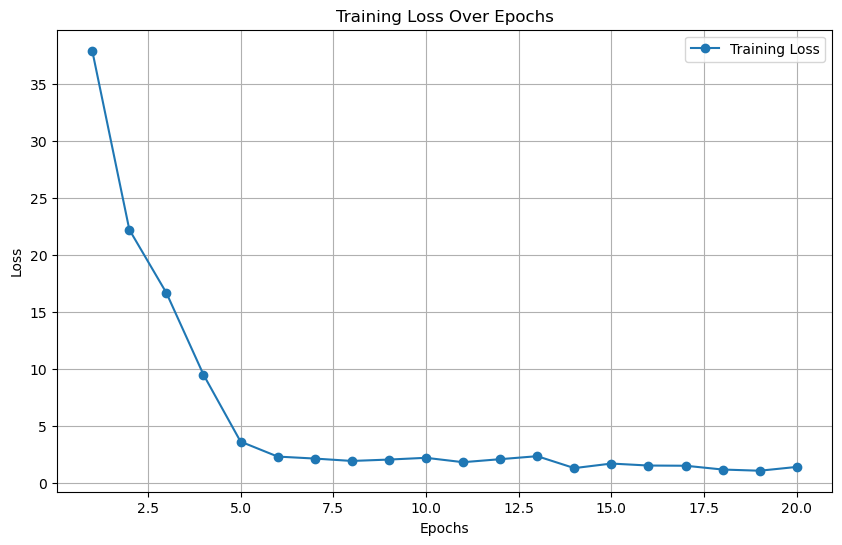

In [54]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), train_losses, label="Training Loss", marker='o')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss Over Epochs")
plt.legend()
plt.grid(True)
plt.show()

In [55]:
# model_path = "/home/eflammere/BreastCancerQuanvolution/Quantum/checkpoints/BCDR/model_checkpoint_epoch_20.pth"
# model.load_state_dict(torch.load(model_path, weights_only=True))

test_loss = 0.0
test_labels, test_predictions = [], []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.squeeze(1).to(device), labels.squeeze().to(device)
        output = model(images)
        loss = criterion(output, labels)
        test_loss += loss.item()
        test_labels.append(labels)
        test_predictions.append(output)

test_labels = torch.cat(test_labels)
test_predictions = torch.cat(test_predictions)

test_accuracy = accuracy_score(
    test_labels.cpu().numpy(), test_predictions.argmax(dim=1).cpu().numpy()
)
test_precision = precision_score(
    test_labels.cpu().numpy(), test_predictions.argmax(dim=1).cpu().numpy(), 
    average="weighted", zero_division=0
)
test_recall = recall_score(
    test_labels.cpu().numpy(), test_predictions.argmax(dim=1).cpu().numpy(), 
    average="weighted", zero_division=0
)
test_f1 = f1_score(
    test_labels.cpu().numpy(), test_predictions.argmax(dim=1).cpu().numpy(), 
    average="weighted", zero_division=0
)
test_auc = roc_auc_score(
    test_labels.cpu().numpy(), test_predictions[:, 1].cpu().numpy()
)

print("\nFinal Test Evaluation:")
print(f"Test Loss: {test_loss / len(test_loader):.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test F1 Score: {test_f1:.4f}")
print(f"Test AUC: {test_auc:.4f}")


Final Test Evaluation:
Test Loss: 10.3914
Test Accuracy: 0.8000
Test Precision: 0.7761
Test Recall: 0.8000
Test F1 Score: 0.7432
Test AUC: 0.5430


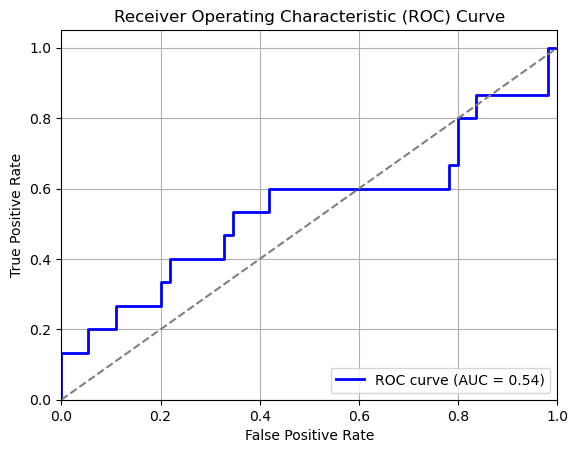

ROC curve data exported to 'roc_curve_data_BCDR.csv'


In [56]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(
    test_labels.cpu().numpy(), test_predictions[:, 1].cpu().numpy()
)
roc_auc = auc(false_positive_rate, true_positive_rate)

plt.figure()
plt.plot(false_positive_rate, true_positive_rate, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--') 
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

dataset_name = "BCDR"
roc_data = pd.DataFrame({
    'Dataset': [dataset_name] * len(false_positive_rate),
    'False Positive Rate': false_positive_rate,
    'True Positive Rate': true_positive_rate,
    'Thresholds': thresholds
})
roc_data.to_csv(f'/home/eflammere/BreastCancerQuanvolution/Quantum/checkpoints/BCDR/224x224/1/roc_curve_data_{dataset_name}.csv', index=False)

print(f"ROC curve data exported to 'roc_curve_data_{dataset_name}.csv'")


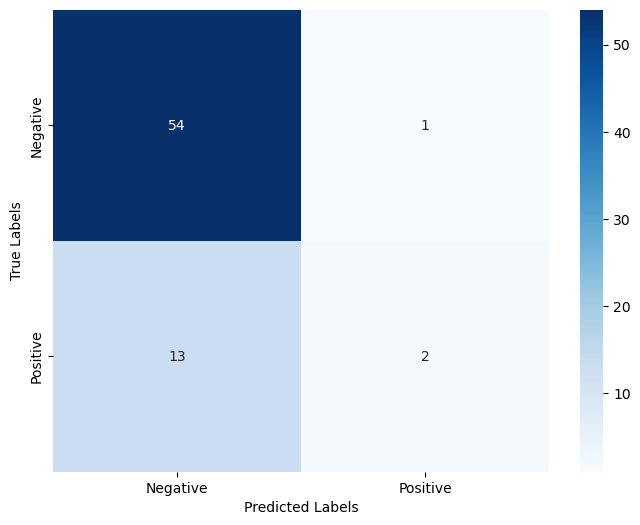

In [57]:
cm = confusion_matrix(test_labels.cpu().numpy(), test_predictions.argmax(dim=1).cpu().numpy(), labels=[0, 1])
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()